<a href="https://colab.research.google.com/github/sasansharee/Sasan_MMA_Assisgnments/blob/main/Linear_Classification_SVM_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Face Recognition (from Python Data Science Handbook by Jake VanderPlas)
* As an example of support vector machines in action, let's take a look at the facial recognition problem
* We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures
* A fetcher for the dataset is built into Scikit-Learn:





In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.datasets import fetch_lfw_people

In [5]:
faces = fetch_lfw_people(min_faces_per_person = 60)

In [6]:
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [7]:
print(faces['data'].shape)
print(faces['images'].shape)
print(faces['target'].shape)
print(faces['target_names'].shape)

(1348, 2914)
(1348, 62, 47)
(1348,)
(8,)


In [8]:
np.unique(faces['target'], return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 77, 236, 121, 530, 109,  71,  60, 144]))

* Let's plot a few of these faces to see what we're working with:

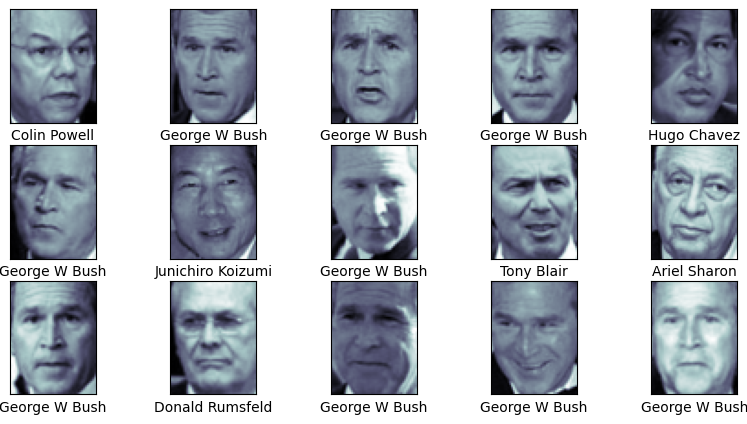

In [9]:
fig, axes = plt.subplots(3,5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(faces['images'][i], cmap = 'bone')
  ax.set(xticks = [], yticks = [],
         xlabel = faces.target_names[faces.target[i]])

* Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (we will learn about PCA later) to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [10]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
pipe = Pipeline(steps = [('pca' , PCA(n_components = 150, whiten = True, random_state = 42)),
                         ('svc' , SVC(kernel = 'rbf', class_weight = 'balanced'))])

* For the sake of testing our classifier output, we will split the data into a training and testing set:

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state = 42)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1011, 2914)
(337, 2914)
(1011,)
(337,)


* Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:



In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {'svc__C' : [1, 5, 10, 50],
              'svc__gamma' : [0.0001, 0.0005, 0.001, 0.005]}

In [17]:
grid = GridSearchCV(pipe, param_grid = param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]})

In [18]:
grid.best_params_

{'svc__C': 5, 'svc__gamma': 0.001}

In [19]:
grid.best_score_

np.float64(0.828893332683022)

In [20]:
estim = grid.best_estimator_

In [21]:
y_predict = estim.predict(X_test)

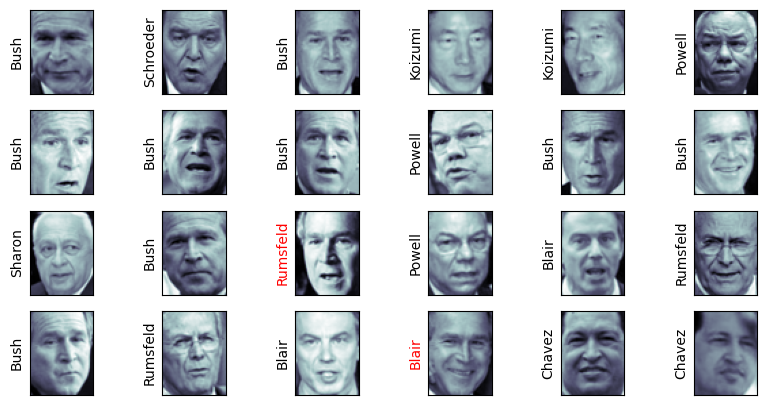

In [22]:
fig, axes = plt.subplots(4, 6, figsize = (10, 5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(X_test[i].reshape(62, 47), cmap = 'bone')
  ax.set(xticks = [], yticks = [])
  ax.set_ylabel(faces.target_names[y_predict[i]].split()[-1],
                color = 'black' if y_predict[i] == y_test[i] else 'red')

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
print(classification_report(y_test, y_predict, target_names = faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



In [30]:
mat = confusion_matrix(y_test, y_predict)
mat.T

array([[ 13,   1,   1,   2,   0,   2,   0,   1],
       [  0,  60,   2,  10,   0,   0,   0,   0],
       [  2,   3,  26,   5,   1,   0,   0,   0],
       [  0,   2,   0, 101,   0,   1,   0,   0],
       [  0,   0,   0,   4,  19,   2,   0,   0],
       [  0,   0,   0,   1,   0,  14,   0,   0],
       [  0,   0,   0,   1,   1,   0,  12,   0],
       [  0,   2,   2,   2,   2,   1,   0,  41]])

Text(113.92222222222219, 0.5, 'Predicted Label')

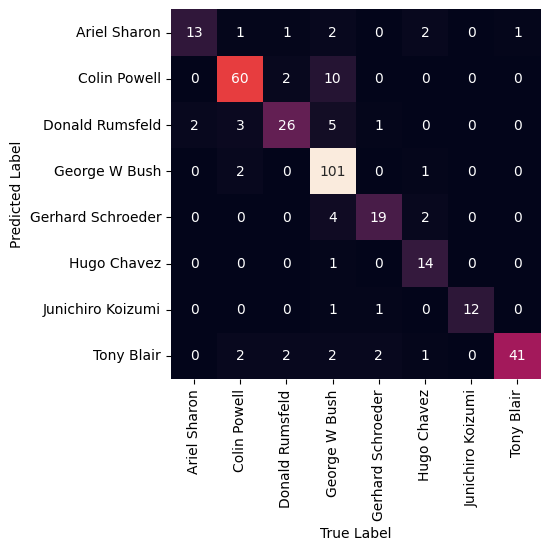

In [36]:
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
            xticklabels = faces.target_names,
            yticklabels = faces.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')